First production dense AE with SM dataset externally loaded

In [1]:
AEversion = '2'

In [2]:
import numpy as np
import os, sys, pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

Error on querying NVIDIA devices. Use --debug flag for details


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190702_50part_PtOrder_v1/{}.npy', N_part=20, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e5)
dataset.charge(dataset.SMMix_train)

Expected 0.10M train
Expected 0.10M val

Loading Wlnu
Loading qcd
Loading Zll
Loading ttbar
+--------+----------+-------+-----+
| Sample | Evts tot | Train | Val |
+--------+----------+-------+-----+
|  Wlnu  |  2000k   |  59k  | 59k |
|  qcd   |   690k   |  34k  | 34k |
|  Zll   |  1000k   |   7k  |  7k |
| ttbar  |  1000k   |   0k  |  0k |
+--------+----------+-------+-----+
Tot training 0.10 M
Tot val 0.10 M


## Define the model

In [10]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=self.p*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
#                                 nn.ELU(),
#                                 nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,1], min_val=-5, max_val=5).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,2]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        # charge
        charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        charge = torch.argmax(charge_cat, dim=1).view(-1, self.No, 1) - 1.
        # pId
        pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        pId = torch.argmax(pId_cat, dim=1).view(-1, self.No, 1)
        
        x = torch.cat((pt,eta, phi, charge.float(), pId.float()), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [11]:
Latent_dimension = int(0.5*dataset.inputs.shape[1])
Hidden_dimension = int(0.5*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=55, bias=True)
      (1): ReLU()
      (2): Linear(in_features=55, out_features=10, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=10, out_features=55, bias=True)
      (1): ReLU()
      (2): Linear(in_features=55, out_features=100, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 12364


In [12]:
model.useGPU(0)

GPU not available


## Loss

In [29]:
def criterion(x_in, x_out, reduction='mean'):
    flattened_shape = x_in.shape[1]*x_in.shape[2]
    out = F.l1_loss(x_in.view(-1, flattened_shape), 
                    x_out.view(-1, flattened_shape), 
                    reduction='none'
                    )
    out_per_evt = torch.sum(out, dim=1)
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [14]:
training_params = {'batch_size': 5000,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 5

In [15]:
torch.autograd.set_detect_anomaly(True);

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.zero_grad()

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [17]:
train_loss = []
loss_history = {'train': [], 'val': []}
for epoch in range(1, max_epochs+1):
    batch_loss = []
    
    #Training
    model.train()
    dataset.charge(dataset.SMMix_train)
    train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
    pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch-1))
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(loss_history['train']) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    aux_loss = 0
    N_batches = 0
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        aux_loss += loss.item()
        N_batches += 1
    batch_loss.append(aux_loss/N_batches)
    
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(loss_history['train']) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
    if len(loss_history['train']) > 1:
        d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout)
    
    loss_history['train'].append(batch_loss)
    
    #Validation
    dataset.charge(dataset.SMMix_val)
    val_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
    aux_loss = 0
    N_batches = 0
    for local_x, _ in val_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        aux_loss += loss.item()
        N_batches += 1
    loss_history['val'].append(aux_loss/N_batches)
    printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
    print(printout)
    
    print('')
    if not earlyStopping.check(loss_history['val'][-1]):
        break

    scheduler.step(batch_loss[-1])

model.eval();

Epoch 0: [####################]  100% - Tot. time: 3.7 s            
Loss: 1.51e+00
Val Loss: 1.51e+00

Epoch 1: [####################]  100% - Tot. time: 3.7 s                        
Loss: 1.41e+00 - Delta: -1.08e-01
Val Loss: 1.41e+00

Epoch 2: [####################]  100% - Tot. time: 3.9 s                        
Loss: 1.38e+00 - Delta: -2.64e-02 - Trend: 8.20e-02
Val Loss: 1.38e+00

Epoch 3: [####################]  100% - Tot. time: 4.4 s                        
Loss: 1.36e+00 - Delta: -2.29e-02 - Trend: 3.49e-03
Val Loss: 1.36e+00

Epoch 4: [####################]  100% - Tot. time: 3.7 s                        
Loss: 1.34e+00 - Delta: -1.95e-02 - Trend: 3.37e-03
Val Loss: 1.34e+00



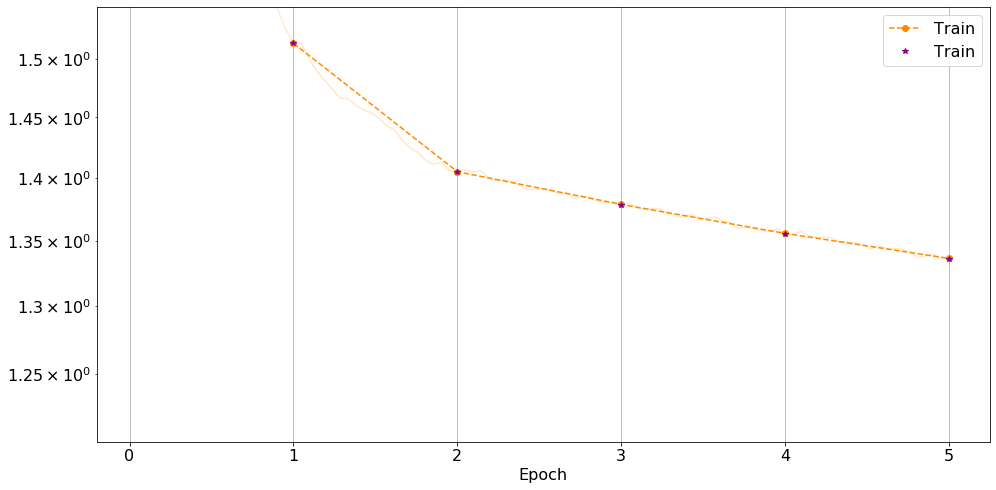

In [18]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(16,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Train', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

# Convergence check

In [19]:
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

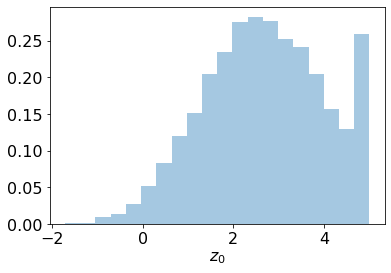

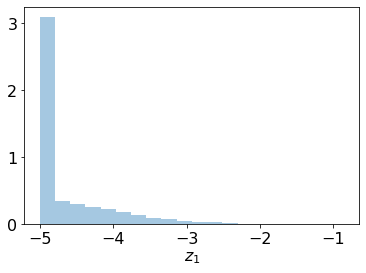

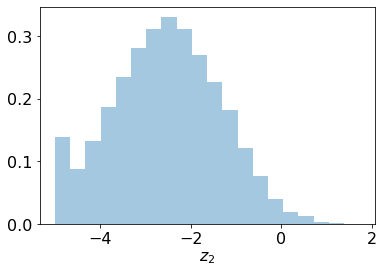

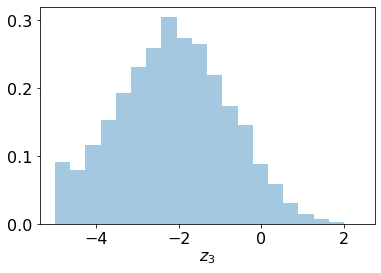

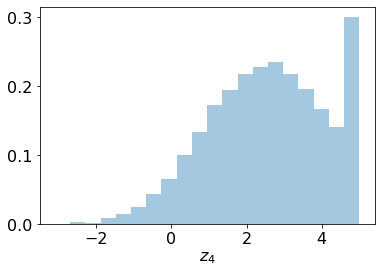

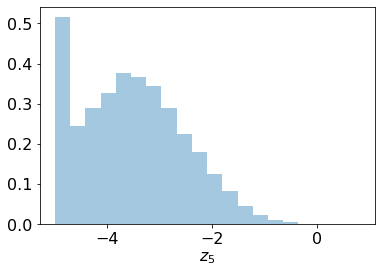

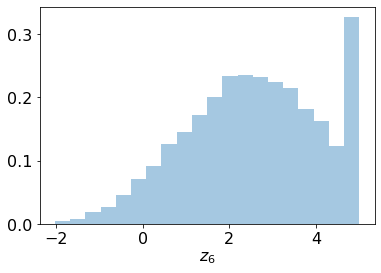

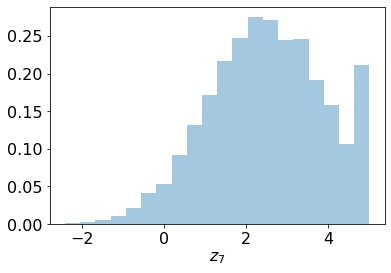

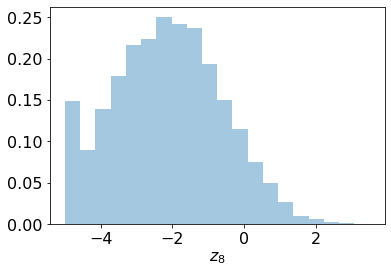

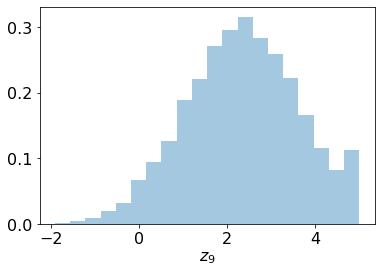

In [20]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

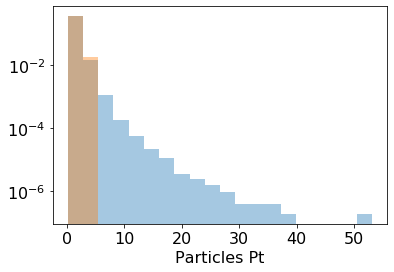

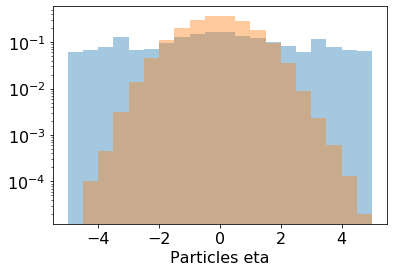

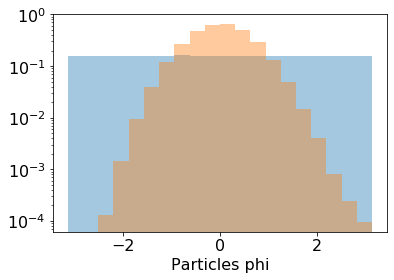

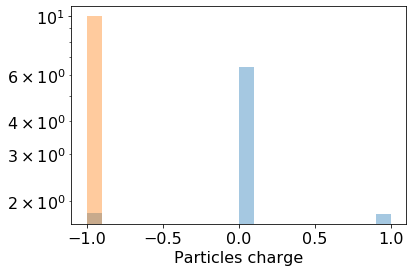

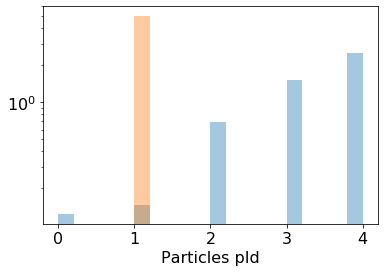

In [21]:
for i in range(x_prime.shape[2]):
    x_aux = x[:,:,i].flatten()
    xp_aux = x_prime[:,:,i].flatten()
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
    plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [22]:
dataset.loadValidationSamples()

Loading Ato4l
Loading leptoquark
Loading hToTauTau
Loading hChToTauNu
Loading Wlnu
Loading qcd
Loading Zll
Loading ttbar
SM Mix limiting stat. sample: qcd (0.66M)
SM validation weights
['Wlnu', 'qcd', 'Zll', 'ttbar']
[0.5921891539876192978, 1.0, 0.13095252987918460496, 0.0058260081574768291037]


In [34]:
dataset.loss = {}

eval_params = {'batch_size': 5000,
               'num_workers': 0
              }
model.eval()
for n in dataset.valSamples.keys():
    dataset.loss[n] = np.zeros((0))
    
    dataset.charge(dataset.valSamples[n])
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [##########]  100% - Tot. time: 1.3 s
leptoquark: [####################]  100% - Tot. time: 7.6 s
hToTauTau: [####################]  100% - Tot. time: 13.6 s
hChToTauNu: [####################]  100% - Tot. time: 9.6 s
Wlnu: [####################]  100% - Tot. time: 54.4 s
qcd: [####################]  100% - Tot. time: 21.0 s
Zll: [####################]  100% - Tot. time: 30.0 s
ttbar: [####################]  100% - Tot. time: 30.7 s


In [ ]:
def createROC_curve(dataset):
    loss_dic = dataset.loss
    weight_dic = dict(zip(dataset.SM_names, dataset.SM_val_weights))
    
    p_SM = np.logspace(base=10, start=-7, stop=0, num=100)
    p_SM[-1] = 0.999

    t_SM = np.concatenate((loss_dic['Wlnu'], 
                           loss_dic['qcd'],
                           loss_dic['Zll'],
                           loss_dic['ttbar']
                          ))
    
    w_SM = np.concatenate((np.full_like(loss_dic['Wlnu'], weight_dic['Wlnu'], np.float128),
                           np.full_like(loss_dic['qcd'], weight_dic['qcd'], np.float128),
                           np.full_like(loss_dic['Zll'], weight_dic['Zll'], np.float128),
                           np.full_like(loss_dic['ttbar'], weight_dic['ttbar'], np.float128)
                          ))
    
    i_sort = np.argsort(t_SM)
    
    t_SM = t_SM[i_sort]
    w_SM = w_SM[i_sort]
    
    l = np.zeros(4)
    for i,n in enumerate(dataset.SM_names):
            l[i] = dataset.valSamples[n].shape[0]
    i_min = np.argmin(l/dataset.SM_fraction)
    
    cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
    print 'CumSum accuracy:', cum_sum[-1]
    
    idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
    q_SM = t_SM[idx_q]
    
    for n in BSM_samples:
        out = loss_sig[n][ll] > np.atleast_2d(q_SM).T
        p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/loss_sig[n].shape[1])
        
        roc_auc = np.trapz(p_BSM, p_SM)
        
        dic2save = {'eff_BSM':p_BSM, 'eff_SM':p_SM, 'roc_auc':roc_auc}
        fileout = open('VAE_all-in-one_v{}_ROC{}_dict_{}.pkl'.format(VAEversion, ll, n), 'w')
        pickle.dump(file=fileout, obj=dic2save)
        fileout.close()
    
        ax_arr_ROC.plot(p_SM, p_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
        
    ax_arr_ROC.legend(loc="lower right")
    f_ROC.savefig('plots/ROC_VAE'+str(ll)+'.png')